# Oregon Wildlife - Image Classification Capstone - Model Optimization with Batch Normalization 

## David Lappin
### BrainStation
#### 3/1/2023 - 4/10/2023

# Packages Import:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL 
from glob import glob
import seaborn as sns
import visualkeras


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

# Overview

# Import Data:

In [2]:
#set local path to files for basic exploration

trainpath = 'data/oregon_wildlife/' # This is the relative path to the data
valpath = 'data/oregon_wildlife_validation/' # This is the relative path to the data
testpath = 'data/oregon_wildlife_test/' # This is the relative path to the data

Ensure Data is still in the same state as we left it from the previous EDA before modeling.

In [3]:
#check number of images in train folder

totalcount_train = []
image_files = os.listdir(trainpath)

for file in image_files:
    
    count = len(list(glob(f'data/oregon_wildlife/{file}/*')))
    totalcount_train.append(count)
    print(f'{count}: {file}')
    
print(f'Total images: {sum(totalcount_train)}')

588: bald_eagle
560: black_bear
535: bobcat
558: canada_lynx
580: columbian_black-tailed_deer
518: cougar
581: coyote
608: deer
505: elk
513: gray_fox
575: gray_wolf
420: mountain_beaver
536: nutria
569: raccoon
495: raven
602: red_fox
426: ringtail
540: seals
570: sea_lions
571: virginia_opossum
Total images: 10850


In [4]:
#check number of images in Validation folder

totalcount_validation = []
image_files = os.listdir(valpath)
for file in image_files:
    
    count = len(list(glob(f'data/oregon_wildlife_validation/{file}/*')))
    totalcount_validation.append(count)
    print(f'{count}: {file}')
    
print(f'Total images: {sum(totalcount_validation)}')

135: bald_eagle
135: black_bear
135: bobcat
135: canada_lynx
135: columbian_black-tailed_deer
135: cougar
135: coyote
135: deer
135: elk
135: gray_fox
135: gray_wolf
135: mountain_beaver
135: nutria
135: raccoon
135: raven
135: red_fox
135: ringtail
135: seals
135: sea_lions
135: virginia_opossum
Total images: 2700


In [5]:
#check number of images in test folder

totalcount_test = []
image_files = os.listdir(testpath)

for file in image_files:
    
    count = len(list(glob(f'data/oregon_wildlife_test/{file}/*')))
    totalcount_test.append(count)
    print(f'{count}: {file}')
    
print(f'Total images: {sum(totalcount_test)}')

20: bald_eagle
20: black_bear
20: bobcat
20: canada_lynx
20: columbian_black-tailed_deer
20: cougar
20: coyote
20: deer
20: elk
20: gray_fox
20: gray_wolf
20: mountain_beaver
20: nutria
20: raccoon
20: raven
20: red_fox
20: ringtail
20: seals
20: sea_lions
20: virginia_opossum
Total images: 400


### Observations: 
Everything looks the same.

# Prepare Data:

In [164]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [165]:
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  trainpath,
  label_mode='int',
  seed=7,
  image_size=IMG_SIZE,
  batch_size=batch_size)


val_set = tf.keras.preprocessing.image_dataset_from_directory(
  valpath,
  label_mode='int',
  seed=7,
  image_size=IMG_SIZE,
  batch_size=batch_size)

Found 10850 files belonging to 20 classes.
Found 2700 files belonging to 20 classes.


**Note** These values match the counts from the directory above. 

# Create and Compile Updated Model

Similar to our preliminary compatibility testing in the EDA section we are going to create a simple Convolutional Neural Network (CNN) based in TF/Keras for our baseline model.

In [166]:
#adjust the prefetching for performance

AUTOTUNE = tf.data.AUTOTUNE #Autotune optimizes CPU uptime for each batch

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) #cache stores data in memory after 1st epoch for faster iterations
val_set = val_set.cache().prefetch(buffer_size=AUTOTUNE) #prefetch allows for overlapping 


In [167]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


In [168]:
#scales

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [169]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')



In [170]:
base_model.trainable = False

In [171]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_28[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [172]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [173]:
prediction_layer = tf.keras.layers.Dense(20, activation='softmax', name='prediction')

In [174]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [175]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [176]:
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                          

In [177]:
# set stopping criteria

callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.05, patience=5)

In [178]:
epochs = 25

history = model.fit(   
  train_set,            
  validation_data=val_set, 
  epochs=epochs,
  callbacks = [callbacks]
)

Epoch 1/25


340/340 [==============================] - 128s 300ms/step - loss: 2.5038 - accuracy: 0.2717 - val_loss: 1.5928 - val_accuracy: 0.5807
Epoch 2/25
340/340 [==============================] - 98s 289ms/step - loss: 1.5302 - accuracy: 0.5545 - val_loss: 1.1010 - val_accuracy: 0.7019
Epoch 3/25
340/340 [==============================] - 102s 299ms/step - loss: 1.2135 - accuracy: 0.6375 - val_loss: 0.9204 - val_accuracy: 0.7448
Epoch 4/25
340/340 [==============================] - 99s 290ms/step - loss: 1.0500 - accuracy: 0.6797 - val_loss: 0.8180 - val_accuracy: 0.7644
Epoch 5/25
340/340 [==============================] - 100s 293ms/step - loss: 0.9681 - accuracy: 0.6982 - val_loss: 0.7579 - val_accuracy: 0.7778
Epoch 6/25
340/340 [==============================] - 99s 292ms/step - loss: 0.9041 - accuracy: 0.7184 - val_loss: 0.7202 - val_accuracy: 0.7915
Epoch 7/25
340/340 [==============================] - 99s 290ms/step - loss: 0.8632 - accuracy: 0.7269 - val_loss: 0.6939 - val_accuracy: 

In [208]:
#save the model weights for use in predictions later if desired

model.save('models/MobileNetV2.h5')

# Preliminary Evaluation

We can visualize the model perfmormance.

##### SOURCE - plot code base from TF Guide:
https://www.tensorflow.org/tutorials/images/classification

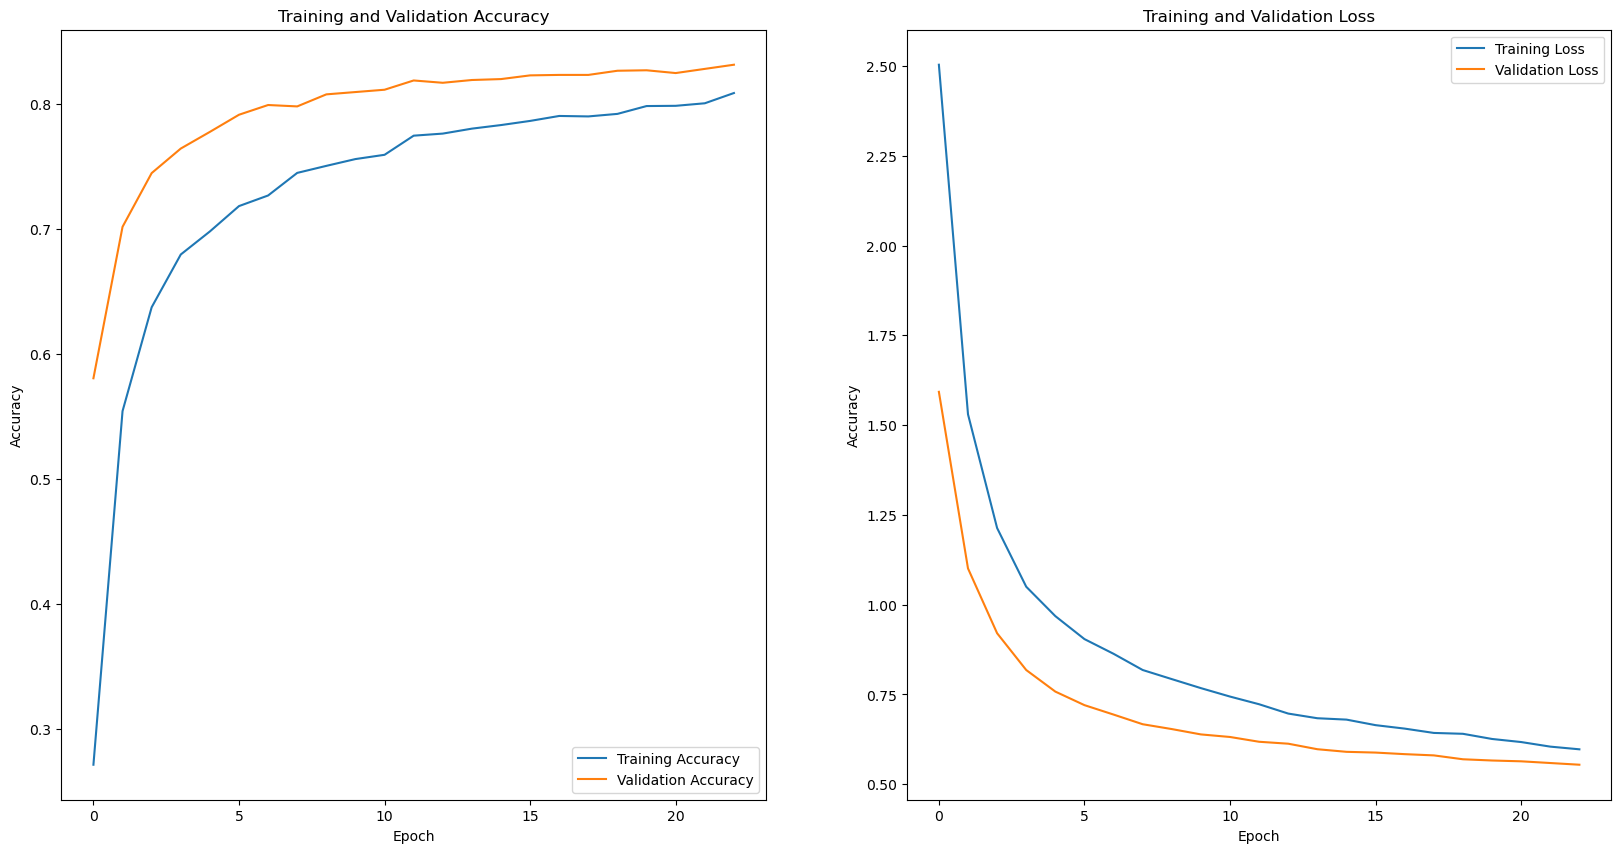

In [180]:
#visualize model performance after 30 

#pull out the accuracy and validation accuracies from model fit history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#pull out the loss data from the model fit history
loss = history.history['loss']
val_loss = history.history['val_loss']

#x lab range defined by the # of epochs ran
epochs_range = range(len(acc))

#training vs Validation Accuracies
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
#plt.axvline(31, color = "black", linestyle = '--', linewidth = 1, alpha = 0.75)
#plt.axvline(41, color = "black", linestyle = '--', linewidth = 1, alpha = 0.75)
#plt.axhline(0.39, color = "black", linestyle = '-', linewidth = 1, alpha = 0.75, label = 'Optimal Epochs (30)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#visualize loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations

# Import Test Data and Make Predictions

In [184]:
#import test set directory for predictions

test_set = tf.keras.preprocessing.image_dataset_from_directory(
  testpath,
  image_size=IMG_SIZE,
  label_mode = 'categorical') #since these are not for training we can load as categorical rather than integer

Found 400 files belonging to 20 classes.


#### SOURCE

Found way to extract multiple predictions across whole dataset from answer by (Frightera, 2021)
https://stackoverflow.com/questions/68121629/trying-to-extract-y-val-from-dataset-throws-all-the-input-arrays-must-have-same

In [185]:
#generate predictions on test data

predictions = np.array([]) #empty list for predictions
labels =  np.array([]) #empty list for labels


for x, y in test_set:
  
  #generate predictions 
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)]) 

  #generate true labels
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

1/1 [==============================] - 1s 612ms/step


In [186]:
# generate a tensorflow confusion matrix from the predictions and true labels above

con_mat = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

In [187]:
#normalize the values such that they fit on a 0-1 scale
normalized_conf_mat = con_mat / con_mat.sum(axis=1)

In [188]:
#define the class names and create temp dataframe to that we can plot using the class names (instead of integers)

class_names = test_set.class_names
con_mat_df = pd.DataFrame(normalized_conf_mat, index=class_names, columns=class_names)

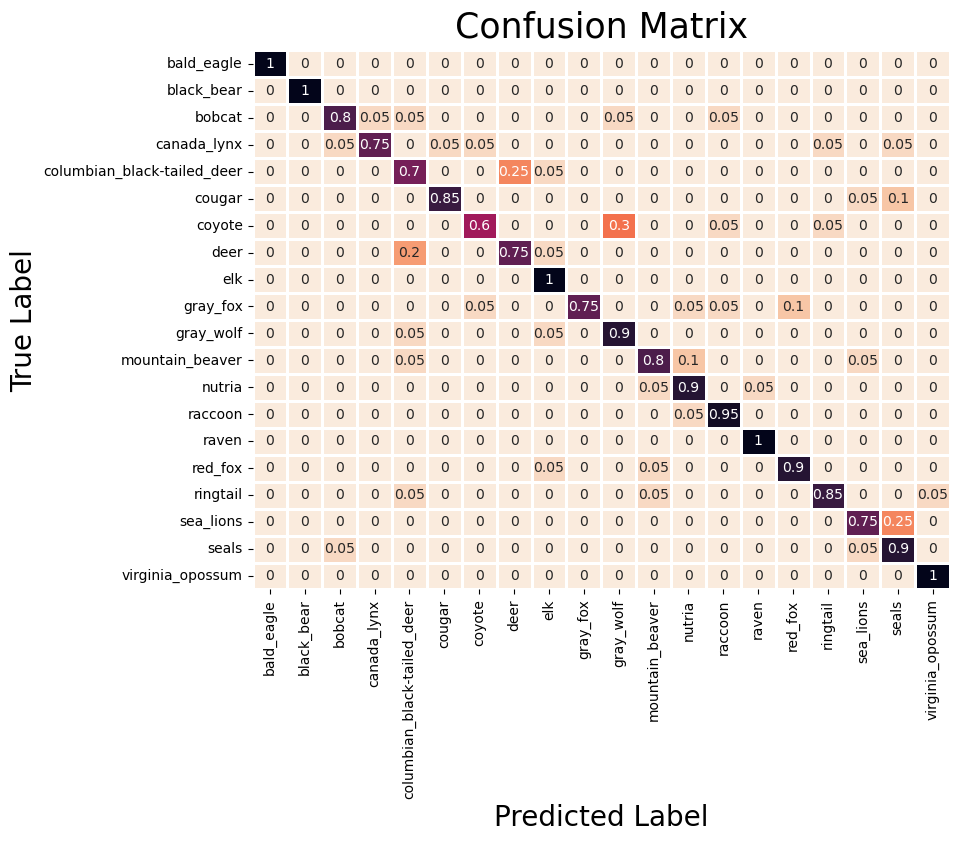

In [189]:
#plot confusion matrix using the data frame with class names created above
plt.figure(figsize = (9,7))
sns.heatmap(con_mat_df,
            annot=True,
            cbar=False,
            cmap="rocket_r",
            linewidths=1
           )
plt.title('Confusion Matrix',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()

### Observations

In [190]:
#generate classification report from predictions

target_names = test_set.class_names
print(classification_report(labels, predictions, target_names = target_names))

                             precision    recall  f1-score   support

                 bald_eagle       1.00      1.00      1.00        20
                 black_bear       1.00      1.00      1.00        20
                     bobcat       0.89      0.80      0.84        20
                canada_lynx       0.94      0.75      0.83        20
columbian_black-tailed_deer       0.64      0.70      0.67        20
                     cougar       0.94      0.85      0.89        20
                     coyote       0.86      0.60      0.71        20
                       deer       0.75      0.75      0.75        20
                        elk       0.83      1.00      0.91        20
                   gray_fox       1.00      0.75      0.86        20
                  gray_wolf       0.72      0.90      0.80        20
            mountain_beaver       0.84      0.80      0.82        20
                     nutria       0.82      0.90      0.86        20
                    raccoon      

To sort and look closer at the data we can translate the above information into a pandas dataframe so we can sort/agg/visualize the data easier if desired.

##### SOURCE - classification report to pandas df:

https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format

In [191]:
#translate the classification report into pd df

classification_report_report = classification_report(labels, predictions, target_names = target_names, output_dict = True)
classification_report_df = pd.DataFrame(classification_report_report).transpose()
classification_report_df

,precision,recall,f1-score,support
bald_eagle,1.000000,1.0000,1.000000,20.0000
black_bear,1.000000,1.0000,1.000000,20.0000
bobcat,0.888889,0.8000,0.842105,20.0000
canada_lynx,0.937500,0.7500,0.833333,20.0000
columbian_black-tailed_deer,0.636364,0.7000,0.666667,20.0000
cougar,0.944444,0.8500,0.894737,20.0000
coyote,0.857143,0.6000,0.705882,20.0000
deer,0.750000,0.7500,0.750000,20.0000
elk,0.833333,1.0000,0.909091,20.0000
gray_fox,1.000000,0.7500,0.857143,20.0000


### Observations

In [192]:
#best f1 scores

classification_report_df.sort_values('f1-score', ascending = False).head(5)

,precision,recall,f1-score,support
bald_eagle,1.000000,1.0,1.000000,20.0
black_bear,1.000000,1.0,1.000000,20.0
virginia_opossum,0.952381,1.0,0.975610,20.0
raven,0.952381,1.0,0.975610,20.0
elk,0.833333,1.0,0.909091,20.0


In [193]:
#worst f1 scores

classification_report_df.sort_values('f1-score', ascending = False).tail(5)

,precision,recall,f1-score,support
sea_lions,0.833333,0.75,0.789474,20.0
seals,0.692308,0.90,0.782609,20.0
deer,0.750000,0.75,0.750000,20.0
coyote,0.857143,0.60,0.705882,20.0
columbian_black-tailed_deer,0.636364,0.70,0.666667,20.0


### Observations

# Optional Load for Future Model Predictions:

If desired in the future, the code below can be used as an example for loading the model to predict on new data or to continue training. The '.h5' file extension saves the model construction, the trained weights, and time information from `compile()`.

##### SOURCE
https://www.tensorflow.org/guide/keras/save_and_serialize

In [124]:
#optional code to re-load and predict on new data

load_model = keras.models.load_model("models/Reg_model.h5") 


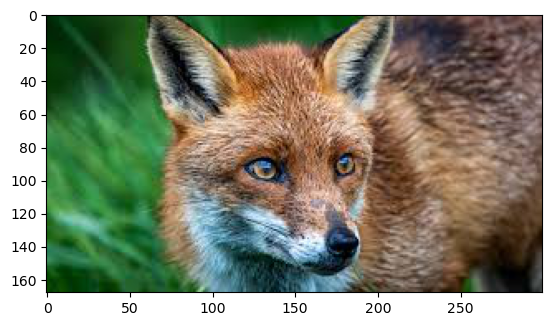

In [194]:
img_path = "randphotos/foximage1.jpg"
img = image.load_img(img_path)
plt.imshow(img)
plt.show()

##### SOURCE - For predicting new data below - TF guide
https://www.tensorflow.org/tutorials/images/classification#predict_on_new_data

In [195]:
img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))


1/1 [==============================] - 1s 1s/step
This image most likely belongs to red_fox with a 8.13 percent confidence.


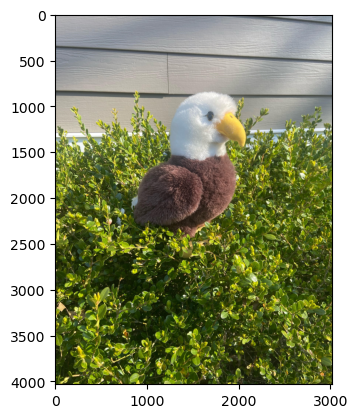

In [196]:
img_path = "randphotos/eagle3.jpg"
img = image.load_img(img_path)
plt.imshow(img)
plt.show()

In [197]:
img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))


1/1 [==============================] - 0s 45ms/step
This image most likely belongs to bald_eagle with a 6.21 percent confidence.


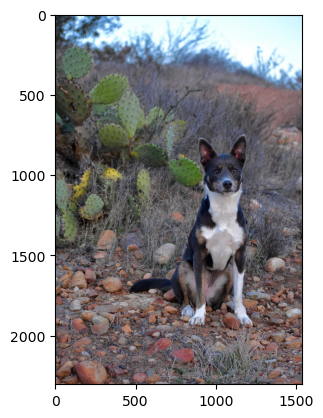

In [209]:
img_path = "randphotos/fizz1.jpg"
img = image.load_img(img_path)
plt.imshow(img)
plt.show()

In [210]:
img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = load_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))


NameError: name 'load_model' is not defined

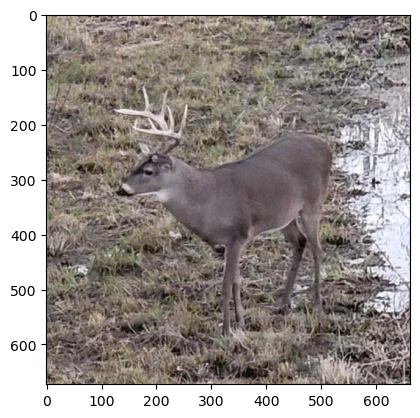

In [198]:
img_path = "randphotos/daldeer1.jpg"
img = image.load_img(img_path)
plt.imshow(img)
plt.show()

In [199]:
img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))


1/1 [==============================] - 0s 43ms/step
This image most likely belongs to columbian_black-tailed_deer with a 6.70 percent confidence.


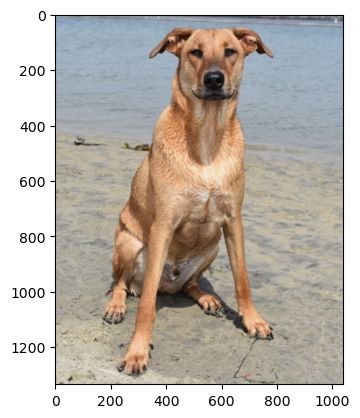

In [213]:
img_path = "randphotos/chompy1.jpg"
img = image.load_img(img_path)
plt.imshow(img)
plt.show()

In [214]:
img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))


1/1 [==============================] - 0s 47ms/step
This image most likely belongs to cougar with a 5.73 percent confidence.


# Summary and Next Steps